In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(sys.version)

3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]


In [2]:
# To fix https://github.com/bstriner/keras-tqdm/issues/21#issuecomment-443019223

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

In [5]:

from pytorch_utils.imports import *
from pytorch_utils.hooks import Hook
from pytorch_utils.callbacks import MyLrFinder, RecordMetric
from pytorch_utils.trainer import learn
from pytorch_utils.utils import *

import sys

ModuleNotFoundError: No module named 'torchvision'

In [11]:
assert(torch.__version__ == '1.2.0+cu92')
assert(torchvision.__version__== '0.4.0+cu92')
assert(sys.version[:5] == '3.7.0')
import warnings
warnings.filterwarnings('ignore')

In [6]:
from torchvision.models import resnet34 as resnet
from torchvision.models import googlenet
from torch import nn
from torch import optim

In [13]:
# %load ../Data/data.py

from torchvision import models, transforms

## Create new class definitions for
#- loading data from Image folder (class1, class2, class3...) with optional subset of classes
#- split data into train and val subsets

from torch.utils.data import Dataset
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS, make_dataset, pil_loader

class ImageFolderWithClassSubset(DatasetFolder):
    '''
    Custom Dataset from ImageFolder with subset of classes defined by classes_for_consideration.
    If classes_for_consideration = None, then all classes are choosen.
    '''
    def __init__(self, root, classes_subset = None):
        super().__init__(root, loader = pil_loader, extensions = IMG_EXTENSIONS)
        if classes_subset:
           # check if the classes in classes_subset are part of available classes deteced by DatasetFolder in the root folder
            if all([_ in self.classes for _ in classes_subset]):
                classes, class_to_idx = classes_subset, {classes_subset[i]: i for i in range(len(classes_subset))}
                samples = make_dataset(self.root, class_to_idx, extensions = IMG_EXTENSIONS)
                self.classes = classes
                self.class_to_idx = class_to_idx
                self.samples = samples
                self.targets = [s[1] for s in samples]
            else:
                print("Certain Class in classes_subset is not available in possible classes. Check your classes_subset. Choosing all classes instead")

class TrainValSubsets(Dataset):
    '''
    Subset a dataset based on indices
    '''
    def __init__(self, dataset, indices, transforms = None):
        self.subset = dataset
        self.indices = indices
        self.transforms = transforms
        
        if not self.transforms:
            self.transforms  = transforms.Compose([transforms.ToTensor()])
        else:
            self.transforms  = transforms
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.subset[self.indices[idx]]
        return (self.transforms(sample[0]), sample[1])
    
## Load all data 

data_root= Path('../Data')
all_data = ImageFolderWithClassSubset(root=data_root, classes_subset=['arts_and_crafts', 'mid-century-modern', 'rustic', 'traditional'])
print(all_data)
print(f"Classes: {all_data.classes}")
print(f"Class Mapping: {all_data.class_to_idx}")

## Create indices for train and val data based on ranom split on whole dataset

#Create random split and create indices for train and val
idx = {}
# torch.manual_seed(1)
rand_idx = torch.randperm(len(all_data))
val_pct = .2
split = int(val_pct*len(rand_idx))
idx['val'] = rand_idx[:split]
idx['train'] = rand_idx[split:]

## Define Transforms on train and val data 


imagenet_stats  = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

trfms = {}
trfms['train'] = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                            transforms.RandomRotation(10),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*imagenet_stats)])

trfms['val'] = transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*imagenet_stats)])


## Create Train and val  datasets and dataloaders

datasets = {}  # Holds datasets
dataloaders = {} # Holds dataloaders
BATCH_SIZE = 32

for datatype in ['train','val']:

    # Dataset
    datasets[datatype] = TrainValSubsets(all_data, idx[datatype],  transforms = trfms[datatype])
    
    # Dataloader
    dataloaders[datatype] = torch.utils.data.DataLoader(datasets[datatype], BATCH_SIZE, num_workers=4, shuffle = True)

## Define a data dict that holds dataloaders, datasets, mappings, transforms, normalizing stats etc.

data = {}
data['norm_stats'] = imagenet_stats
data['ds'] = datasets
data['dl'] = dataloaders
data['classes'] = all_data.classes
data['tfms'] = trfms
data['maping'] = all_data.class_to_idx

# lets check the size of the train image dataset
print(f"Train size: {len(data['ds']['train'])}")

#Test the frist image on val image_dataset
print(f"Val size: {len(data['ds']['val'])}")


Dataset ImageFolderWithClassSubset
    Number of datapoints: 624
    Root location: ../Data
Classes: ['arts_and_crafts', 'mid-century-modern', 'rustic', 'traditional']
Class Mapping: {'arts_and_crafts': 0, 'mid-century-modern': 1, 'rustic': 2, 'traditional': 3}
Train size: 500
Val size: 124


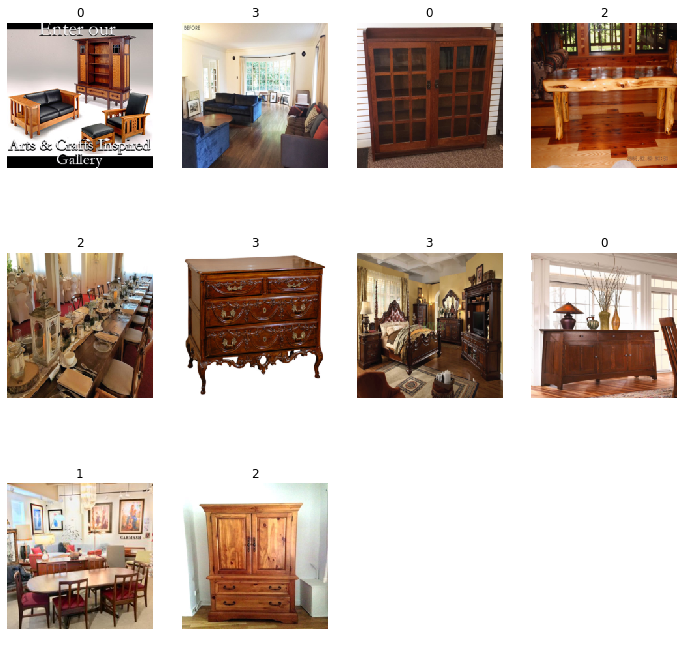

In [14]:
show_batch(data['dl']['val'], classes = data['classes'], normalize_stats=imagenet_stats, plot_num=10)

In [15]:

def change_out_features(model,num_classes):
    in_features = model.fc.in_features 
    model.fc = nn.Linear(in_features, num_classes)
    return model


In [16]:
net = change_out_features(resnet(pretrained = True),num_classes= len(data['classes']))
optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9, weight_decay=1e-4, nesterov=True)    
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer, criterion, checkpoint_source='../Checkpoints/checkpoint_nofc.pth')
testlearner.unfreeze(num_layers = 5) # Unfreeze 5 layers above unfreezen layers.

In [17]:
from pytorch_utils.model_utils import model_summary
model_summary(net, torch.rand(1,3,224,224))

Input: torch.Size([1, 3, 224, 224])
--------------------------------------------------
CONV1
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 3, 224, 224])
Parameters
weight: torch.Size([64, 3, 7, 7])
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
BN1
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
Parameters
weight: torch.Size([64])
bias: torch.Size([64])
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
RELU
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
No Parameters
OUTPUT SHAPE: torch.Size([1, 64, 112, 112])
--------------------------------------------------
MAXPOOL
--------------------------------------------------
INPUT SHAPE: torch.Size([1, 64, 112, 112])
No Parameters
OUTPUT SHAPE: torch.Size([1, 64, 56, 56])
--------------------------------------------------
LAYER

In [18]:
# testlearner.lr_finder(epochs = 20, start_lr = 1E-6, stop_lr = 0.1)

In [19]:
net = change_out_features(resnet(pretrained =True),num_classes= len(data['classes']))
optimizer = optim.SGD(net.parameters(), lr=1E-5, momentum=0.9, weight_decay=1e-4, nesterov=True)    
criterion = nn.CrossEntropyLoss()
testlearner = learn(data, net, optimizer, criterion, checkpoint_source='../Checkpoints/checkpoint_nofc.pth')
testlearner.unfreeze(num_layers=5)
epochs = 1
iterations_per_epoch = len(testlearner.data['dl']['train'])
stepsize = 4 * iterations_per_epoch

Loading model from ../Checkpoints/checkpoint_nofc.pth


Epoch:16 | train Loss: 0.24 | Metric : 91.563
Epoch:16 | val Loss: 0.09 | Metric : 95.201
Saving to ../Checkpoints/checkpoint_nofc.pth
-------------------------


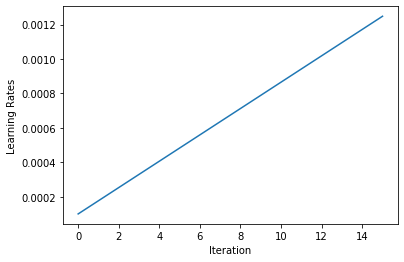

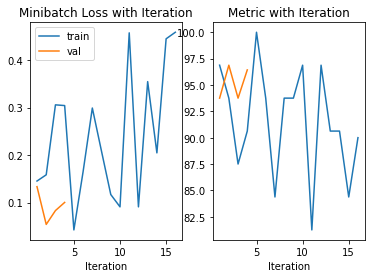

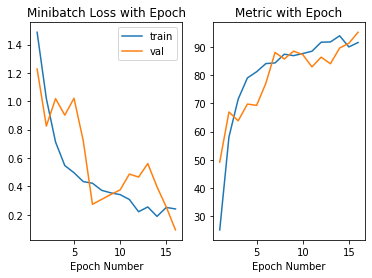

In [42]:
testlearner.cyclic_lr(epochs, 1E-4, 0.5E-2, stepsize, policy = 'triangular')


array([ 1,  7,  8,  4,  5,  2,  6, 11,  9,  0,  3, 10])

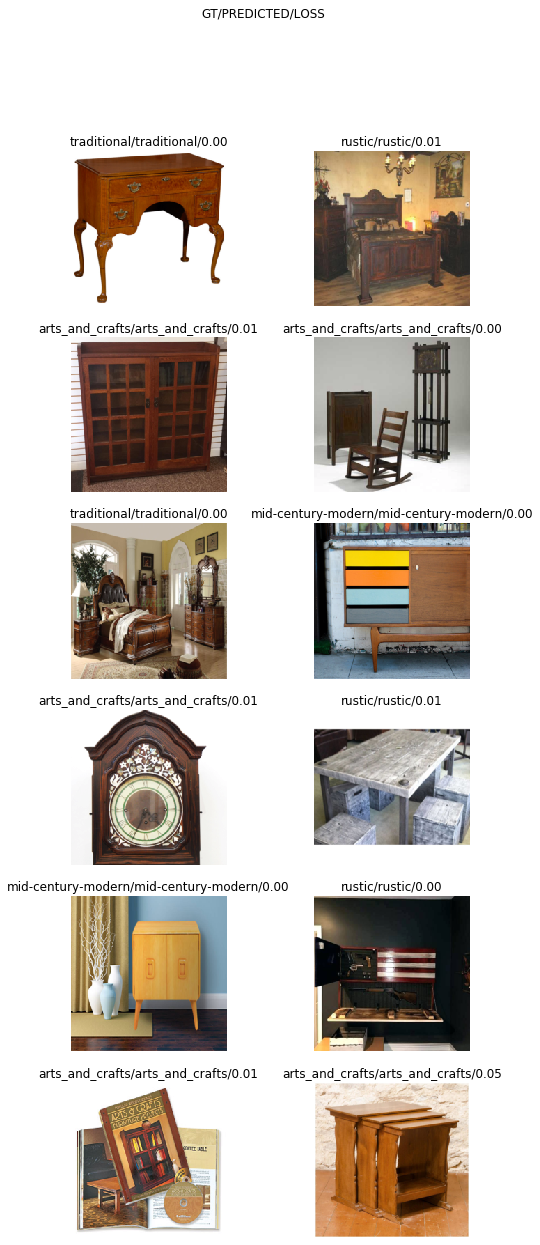

In [43]:
from pytorch_utils.trainer import Interpretration
inference = Interpretration.from_learner(testlearner, data)
inference.plot_top_N_losses()

In [118]:
def denormalize(inputs, normalize_stats):
    mean, std = normalize_stats
    std = torch.tensor(std)
    mean = torch.tensor(mean)
    inputs = inputs.mul(std[None,:,None,None])+mean[None,:,None,None]
    return inputs
 

Actual Class : arts_and_crafts
Label: Probability
arts_and_crafts -> 0.985
traditional -> 0.009
mid-century-modern -> 0.006
rustic -> 0.000


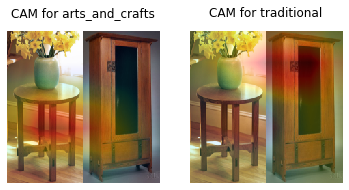

In [214]:
infer_data = data['ds']['val']

# Pick two random images from infer_data
inp1, label = infer_data[torch.randint(low = 0, high = len(infer_data), size = (1,)).item()]
inp2, label2 = infer_data[torch.randint(low = 0, high = len(infer_data), size = (1,)).item()]
inp = torch.cat((inp1, inp2), dim = 2).unsqueeze_(dim=0)

from  torch.nn.modules.upsampling import Upsample
m = Upsample(size = (224, 224), mode='bilinear')
inp = m(inp)


testlearner.model.cpu()
testlearner.model.eval()

with Hook(testlearner.model.layer4) as hook:
    logit = testlearner.model(inp)
out = F.softmax(logit, dim=1).squeeze()
hook.output.detach()

probs, idxs = out.sort(descending=True)

print(f"Actual Class : {data['classes'][label]}")
print("Label: Probability")
      
for label, prob in zip([data['classes'][i] for i in idxs], probs):
    print(f"{label} -> {prob.item():.3f}")  
      
fc_weights = list(net._modules['fc'].parameters())[0]

nc, nf = fc_weights.shape
nb, nf, nh, nw = hook.output_shape

feature_maps = hook.output.squeeze().view(nf,-1)
cam = torch.matmul(fc_weights, feature_maps).view(nc, nh, nw).unsqueeze(dim = 1).detach()
cam_scaled = m(cam)

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.4, N+4)
    return mycmap

#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.jet)
      
ncols = 2      
fig, ax = plt.subplots(1,ncols)

inp_denorm = denormalize(inp, data['norm_stats']) if data['norm_stats'] else inp
for i in range(ncols):
    ax[i].imshow(inp_denorm.squeeze(dim=0).permute(1,2,0))
    ax[i].axis('off')
    ax[i].matshow(cam_scaled[idxs[i]].squeeze(),cmap = mycmap)
    ax[i].set_title(f"CAM for {data['classes'][idxs[i]]}")
